<a href="https://colab.research.google.com/github/rosie-xue/NLP/blob/main/BERT%20%2B%20IMDB%20Text%20Sentiment%20Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 简介
![BERT](./bert.png)
## 背景
- BERT（Bidirectional Encoder Representations from Transformers）是由Google AI团队开发的预训练语言表示模型。

## 核心概念
- BERT是基于Transformer架构的，特别是它的编码器部分。
- 它的创新之处在于使用了掩码语言模型（MLM）和下一个句子预测（NSP）两种训练任务。
- BERT是双向的，这意味着它在处理每个词时会考虑整个句子的上下文。

## 预训练和微调
- BERT模型首先在大量文本数据上进行预训练，以学习语言的通用特征。
- 然后，它可以通过微调（即在特定任务的数据集上进行额外训练）来适应各种NLP任务，如情感分析、问答、命名实体识别等。

# BERT的训练任务

## 掩码语言模型（MLM）
- 在MLM任务中，BERT随机遮蔽输入序列中的一些词元（例如，用[MASK]标记替换），然后尝试预测它们。
- 这种方式使BERT能够学习到词元的双向表示。

## 下一个句子预测（NSP）
- 在NSP任务中，模型获取两个句子作为输入，并预测第二个句子是否是第一个句子的下一个句子。
- 这有助于模型理解句子间的关系，对于理解段落和文章非常重要。

# BERT的影响和应用

- 自发布以来，BERT已成为多种NLP任务的基准测试模型。
- 它在多个NLP评测任务中取得了当时的最佳性能。
- BERT已被广泛应用于各种语言处理任务，如文本分类、命名实体识别、问答系统等。
- 它的出现也催生了一系列基于BERT架构的后续模型，如RoBERTa、ALBERT等。

# 运行环境

```
torch==2.1.0+cu118
transformers==4.35.2
random
numpy
tqdm
matplotlib
scipy
datasets
sklearn
```


In [ ]:
# 如使用colab平台，运行代码前请先安装datasets库
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 23.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.9 MB/s eta 0:00:00


In [ ]:
import torch
import random
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.spatial.distance import cosine
from torch.utils.data import DataLoader
from transformers import BertTokenizer, BertModel, BertForMaskedLM, BertForNextSentencePrediction, BertForSequenceClassification
from transformers import AdamW, get_linear_schedule_with_warmup
from datasets import load_dataset
from sklearn.metrics import accuracy_score

## 加载预训练的BERT模型和分词器

- **分词器加载**：使用`BertTokenizer.from_pretrained('bert-base-uncased')`来加载一个预训练的BERT分词器。`bert-base-uncased`模型处理的文本是小写的。
- **模型加载**：通过`BertModel.from_pretrained('bert-base-uncased', output_attentions=True)`加载与分词器对应的BERT模型。设置`output_attentions=True`可以在模型的输出中获得注意力权重。

## 对文本进行分词

- 使用分词器对文本进行分词，命令为：`tokenizer(text, return_tensors='pt')`。
- `return_tensors='pt'`指定返回的数据格式是PyTorch张量。
- 分词结果`encoded_input`是一个包含分词信息的字典，如token IDs（`input_ids`）和注意力掩码（`attention_mask`）。

## 获取BERT模型的输出

- 将分词结果作为输入传递给BERT模型，使用命令：`model(**encoded_input)`。
- 模型的输出`output`包含了多个部分，例如最后一个隐藏层的状态（`last_hidden_state`）和注意力权重（如果`output_attentions`为True）。


In [ ]:
# 加载预训练的BERT模型和分词器
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased', output_attentions=True)

# 示例文本
text = "Hello, world. This is a BERT model example."

# 对文本进行分词
encoded_input = tokenizer(text, return_tensors='pt')

# 获取BERT模型的输出
output = model(**encoded_input)
print(encoded_input['input_ids'])
print(output.last_hidden_state[0, :])

# BERT 注意力可视化分析

本文档提供了使用BERT模型进行注意力可视化的步骤说明。

## 文本的分词处理

- **分词**：使用 `tokenizer(text, return_tensors='pt')` 对文本 `text` 进行分词处理。`return_tensors='pt'` 表示返回的结果是PyTorch张量格式。

## 获取模型输出和注意力

- **模型输出**：通过 `model(**inputs)` 获取BERT模型对输入文本的输出。这里的输出包括最后一层的隐藏状态和注意力矩阵。
- **注意力矩阵**：`outputs.attentions` 是模型输出的注意力部分，它是一个多维数组，包含了模型每一层的注意力头的信息。

## 选择可视化的层和头

- **指定层和头**：通过设置 `layer = 0` 和 `head = 0`，我们选择模型的第一层和第一个注意力头进行可视化。

## 获取并可视化注意力矩阵

- **可视化注意力矩阵**：使用 `matplotlib` 的 `imshow` 函数将注意力矩阵可视化。这个矩阵表示了输入中的每个词对其他词的注意力分布。

## 设置图表并显示

- **获取分词文本**：使用 `tokenizer.convert_ids_to_tokens()` 将token IDs转换回词汇。
- **设置图表标签**：设置x轴和y轴的标签为分词后的文本，使用 `plt.xticks` 和 `plt.yticks` 添加标签。



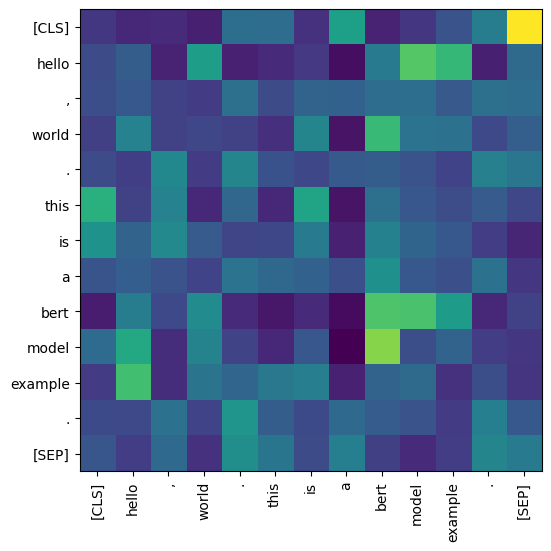

In [ ]:
# 要分析的文本
text = "Hello, world. This is a BERT model example."

# 对文本进行分词处理
inputs = tokenizer(text, return_tensors='pt')

# 获取模型的输出，包括注意力
outputs = model(**inputs)
attentions = outputs.attentions

# 选择要可视化的层和头
layer = 0
head = 0

# 获取注意力矩阵（只用获取 输出 的 注意力 部分）
attention = attentions[layer][0, head].detach().numpy()

# 可视化
plt.figure(figsize=(6,6))
plt.imshow(attention)

# 设置图表
tokenized_text = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
plt.xticks(range(len(tokenized_text)), tokenized_text, rotation=90)
plt.yticks(range(len(tokenized_text)), tokenized_text)
plt.show()

# BERT MLM

## 初始化模型和分词器

- **分词器加载**：使用 `BertTokenizer.from_pretrained('bert-base-uncased')` 来加载一个预训练的BERT分词器。该模型处理的文本是小写的。
- **MLM模型加载**：通过 `BertForMaskedLM.from_pretrained('bert-base-uncased')` 加载用于MLM任务的BERT模型。这个特定的模型经过训练，专门用于预测掩码位置上的词。
- **设置评估模式**：使用 `mlm_model.eval()` 将模型设置为评估模式，这意味着在预测时不会更新模型的权重。

## 文本分词处理

- **定义文本**：定义一个字符串变量 `text`，内容为："The capital of France is [MASK]."。这段文本包含一个掩码标记 [MASK]，BERT模型将被用来预测这个位置的词。

- **分词处理**：使用 `tokenizer(text, return_tensors="pt")` 对文本进行分词处理，并将其转换为模型所需的格式（PyTorch张量）。

## 模型预测

- **预测掩码词**：在不计算梯度的情况下（`torch.no_grad()`），通过 `mlm_model(**inputs)` 对掩码位置进行预测。`outputs.logits` 是模型的原始输出。

## 获取并解析预测结果

- **定位掩码索引**：使用 `torch.where()` 找到输入中 [MASK] 位置的索引。
- **提取预测的token ID**：使用 `argmax()` 从模型输出中提取概率最高的token ID。
- **解码token ID**：通过 `tokenizer.decode()` 将预测的token ID解码为词汇。

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
mlm_model = BertForMaskedLM.from_pretrained('bert-base-uncased')
mlm_model.eval()  # 将模型设置为评估模式
text = "The capital of France is [MASK]."
inputs = tokenizer(text, return_tensors="pt")
with torch.no_grad():
    outputs = mlm_model(**inputs)
    predictions = outputs.logits
masked_index = torch.where(inputs.input_ids == tokenizer.mask_token_id)[1]

predicted_token_id = predictions[0, masked_index].argmax(axis=1)
predicted_token = tokenizer.decode(predicted_token_id)

print(f"Original Text: {text}")
print(f"Predicted Word: {predicted_token}")


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Original Text: The capital of France is [MASK].
Predicted Word: paris


# BERT NSP

## 初始化模型和分词器

- **分词器加载**：使用 `BertTokenizer.from_pretrained('bert-base-uncased')` 来加载一个预训练的BERT分词器。该模型处理的文本是小写的。
- **NSP模型加载**：通过 `BertForNextSentencePrediction.from_pretrained('bert-base-uncased')` 加载用于NSP任务的BERT模型。这个特定的模型经过训练，专门用于预测一个句子是否是另一个句子的下一个句子。
- **设置评估模式**：使用 `nsp_model.eval()` 将模型设置为评估模式，这意味着在预测时不会更新模型的权重。

## 为句子创建编码和分段标记

- **定义文本**：定义两个字符串变量 `text_a` 和 `text_b`，分别包含两个待比较的句子。示例中的句子分别为："The quick brown fox jumps over the lazy dog" 和 "The dog is named Rover"。

- **分词处理**：使用 `tokenizer(text_a, text_b, return_tensors="pt")` 对两个句子进行分词处理，并将其转换为模型所需的格式（PyTorch张量）。

## 模型预测

- **预测关系**：在不计算梯度的情况下（`torch.no_grad()`），通过 `nsp_model(**encoding, return_dict=True)` 对两个句子间的关系进行预测。`outputs.logits` 是模型的原始输出。

## 获取并解析预测结果

- **计算概率**：使用 `torch.nn.functional.softmax()` 将模型的输出转换为概率。
- **提取预测的标签**：使用 `torch.argmax()` 从概率中提取预测标签。


In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
nsp_model = BertForNextSentencePrediction.from_pretrained('bert-base-uncased')
nsp_model.eval()  # 将模型设置为评估模式
text_a = "The quick brown fox jumps over the lazy dog"
text_b = "The dog is named Rover"

# 为句子创建编码和分段标记
encoding = tokenizer(text_a, text_b, return_tensors="pt")
with torch.no_grad():
    outputs = nsp_model(**encoding, return_dict=True)
    logits = outputs.logits
    probabilities = torch.nn.functional.softmax(logits, dim=1)

# 获取预测结果
predicted_label = torch.argmax(probabilities, dim=1)
labels = ['Not Next', 'Next']
print(f"Text A: {text_a}")
print(f"Text B: {text_b}")
print(f"Prediction: {labels[predicted_label]}")


Text A: The quick brown fox jumps over the lazy dog
Text B: The dog is named Rover
Prediction: Not Next


# 基于BERT的IMDB文本情感分类

## 初始化模型和分词器

- **分词器加载**：使用 `BertTokenizer.from_pretrained("bert-base-uncased")` 加载一个分词器，用于将文本转换为模型能理解的格式。
- **分类模型加载**：通过 `BertForSequenceClassification.from_pretrained("bert-base-uncased")` 加载用于序列分类（情感分类）的BERT模型。

## 加载和预处理数据集

- **加载IMDB数据集**：使用 `load_dataset("imdb")` 加载IMDB电影评论数据集，它包含了电影评论的文本和相应的情感标签（正面或负面）。
- **随机选择样本**：从训练集和测试集中各随机选择1000条样本进行训练和评估。
- **创建DataLoader**：使用 `DataLoader` 创建训练集和测试集的迭代器，设置批量大小和是否打乱数据。


`BertForSequenceClassification` 是基于 BERT (Bidirectional Encoder Representations from Transformers) 模型的一个变种，专门用于序列分类任务，例如情感分析或意图识别。它是由 Hugging Face's Transformers 库提供的。

## 初始化参数

初始化 `BertForSequenceClassification` 时的关键参数包括：

- **config**: `BertConfig` 对象，包含模型配置信息。
- **num_labels**: 分类任务的类别数量。例如，对于二元情感分析，该值为 2。

## 模型的输入

模型的主要输入参数包括：

- **input_ids**: 形状为 `(batch_size, sequence_length)` 的张量，包含编码后的输入序列。
- **attention_mask**: 形状相同的张量，用于区分真实数据和填充。
- **token_type_ids**: 当处理两个序列时，此张量用于区分它们。

## 模型的输出

模型输出是一个元组，主要包含：

- **logits**: 形状为 `(batch_size, num_labels)` 的张量，表示每个类别的预测得分。
- **loss** (如果提供了标签): 用于训练的损失值。

In [ ]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
cls_model = BertForSequenceClassification.from_pretrained("bert-base-uncased")

dataset = load_dataset("imdb")

random_train_indices = random.sample(range(len(dataset["train"])), 1000)
random_test_indices = random.sample(range(len(dataset["test"])), 1000)
train_dataset = dataset["train"].select(random_train_indices)
test_dataset = dataset["test"].select(random_test_indices)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# 模型训练与评估

## 训练模型函数 `train_model`

此函数用于训练模型。

### 参数

- `model`: 要训练的BERT模型。
- `train_loader`: 训练数据的DataLoader。
- `optimizer`: 优化器，用于更新模型的权重。
- `lr_scheduler`: 学习率调度器，用于调整学习率。
- `num_epochs`: 训练的总轮次。
- `device`: 训练使用的设备，如CPU或GPU。
- `criterion`: 损失函数。

### 功能

1. **设置模型为训练模式**：确保模型在训练过程中更新权重。
2. **遍历每个epoch**：循环处理每个训练轮次。
3. **数据处理和训练**：对每个batch的数据进行处理，包括文本的分词和转换为张量，然后在指定设备上进行训练。
4. **反向传播和优化**：计算损失，并进行反向传播来优化模型参数。

## 评估模型函数 `evaluate_model`

此函数用于评估模型的性能。

### 参数

- `model`: 要评估的BERT模型。
- `test_loader`: 测试数据的DataLoader。
- `device`: 评估使用的设备，如CPU或GPU。

### 功能

1. **设置模型为评估模式**：确保模型在评估过程中不更新权重。
2. **遍历测试数据**：对测试数据集的每个batch进行迭代。
3. **数据处理和预测**：与训练过程类似，对每个batch的数据进行处理，然后进行预测。
4. **计算准确率**：收集所有预测结果，并与真实标签比较，计算模型的准确率。



In [ ]:
def train_model(model, train_loader, optimizer, lr_scheduler, num_epochs, device, criterion):
    model.train()
    for epoch in range(num_epochs):
        for batch in tqdm(train_loader):
            # TODO: 使用tokenizer处理输入数据，并加载至device
            inputs = tokenizer(batch["text"], padding=True, truncation=True, max_length=512, return_tensors="pt")
            input_ids = inputs["input_ids"].to(device)
            attention_mask = inputs["attention_mask"].to(device)

            # TODO: 将标签数据加载至device..
            labels = batch["label"].to(device)

            # TODO: 计算模型输出和损失
            outputs = model(input_ids, attention_mask=attention_mask)
            loss = criterion(outputs.logits, labels)

            # 反向传播和优化
            loss.backward()
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()

def evaluate_model(model, test_loader, device):
    model.eval()
    predictions = []
    references = []
    for batch in tqdm(test_loader):
        # TODO: 使用tokenizer处理输入数据，并加载至device
        inputs = tokenizer(batch["text"], padding=True, truncation=True, max_length=512, return_tensors="pt").to(device)

        # TODO: 将标签数据加载至device..
        labels = batch["label"].to(device)

        # 计算模型输出
        with torch.no_grad():
            # TODO: 计算模型输出
            outputs = model(**inputs)

        # TODO: 提取logits并生成预测结果
        logits = outputs.logits
        preds = torch.argmax(logits,dim=1)
        predictions.extend(preds.tolist())

        # 收集真实标签用于后续计算准确率
        references.extend(batch["label"].tolist())

    # 计算准确率
    return accuracy_score(references, predictions)


In [ ]:
# 确保模型在CPU或GPU上运行
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cls_model.to(device)

# 微调前评估
pre_tuning_accuracy = evaluate_model(cls_model, test_loader, device)
print(f"Accuracy before fine-tuning: {pre_tuning_accuracy}")

100%|██████████| 125/125 [00:33<00:00,  3.71it/s]

Accuracy before fine-tuning: 0.508


In [ ]:
# 设置训练参数
optimizer = AdamW(cls_model.parameters(), lr=2e-5)
num_epochs = 1
num_training_steps = num_epochs * len(train_loader)
lr_scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)
criterion = nn.CrossEntropyLoss()

# 训练模型
train_model(cls_model, train_loader, optimizer, lr_scheduler, num_epochs, device, criterion)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
100%|██████████| 125/125 [01:29<00:00,  1.40it/s]


In [ ]:
# 微调后评估
post_tuning_accuracy = evaluate_model(cls_model, test_loader, device)
print(f"Accuracy after fine-tuning: {post_tuning_accuracy}")

100%|██████████| 125/125 [00:30<00:00,  4.16it/s]

Accuracy after fine-tuning: 0.889


# QUESTIONS：
1. **注意力机制的优越性是什么？能提供一个实际应用场景吗？**
- 注意力机制通过允许模型在每一步都能够直接访问序列的任意部分，有效地缓解了处理长序列数据时，可能会出现梯度消失或梯度爆炸的问题。
- 注意力机制可以为模型的每个输出提供一个权重，这些权重反映了输入序列中各部分对该输出的重要性。这种特性提高了模型的解释性，使我们能够更清楚地理解模型的决策过程。
- 自注意力机制（Self-Attention）可以并行化计算，而不像RNN那样需要逐步处理序列数据，这显著提高了训练和推理的效率。
- 注意力机制能够捕捉序列中元素之间的全局关系，不再局限于局部信息。这对于理解和生成上下文丰富的序列非常重要。
- **应用场景：**机器翻译。在传统的Seq2Seq模型中，翻译长句子可能会遇到困难，因为句子的前半部分信息在生成译文时容易丢失。引入注意力机制后，模型可以在每个翻译步骤中“注意”到源句子中的相关部分，从而生成更准确和流畅的译文。
   
2. **简述MLM和NSP的训练过程，并分析二者在预训练过程中的作用。**
- **(1) MLM的训练过程:**
- 掩码生成：在输入序列中，随机选择并遮盖一部分词汇（通常是15%的词汇），用特殊的掩码符号"[MASK]"替代。同时，一部分被遮盖的词将被替换为随机的其他词（通常是80%的替换概率），另一部分维持原样。
- 输入构建：将生成的带有掩码的句子作为输入传入预训练模型中。
预测与损失计算：模型会对句子中的每个词进行处理，并尝试预测被遮盖的词。对于每个被遮盖的词，与原始句子中相应的位置进行比较，计算预测词与原始词之间的交叉熵损失。注意，只有被遮盖的词的预测结果会被用来计算损失，其他位置的预测结果会被忽略。
- 反向传播和优化：根据计算得到的损失，使用反向传播算法更新模型中的参数。
- **作用**：通过随机遮盖部分词汇并训练模型预测这些词汇，MLM有助于模型学习到文本的语义信息。这种方式使模型不仅能够理解单词的含义，还能考虑上下文的语义信息，从而提高模型的语义表达能力。
- **(2) NSP的训练过程**
- 数据构建：构建训练数据对，将两个句子按照特定格式进行组合，如"[CLS] 句子 A [SEP] 句子 B [SEP]"。[CLS] token表示句子级别的语义信息，[SEP] token用于分隔不同句子。
- 连续性标记：对于每一对句子，通过判断它们在原文本中是否连续来设置标签。如果是连续的，标签为1；如果不连续，标签为0。
- 输入处理：将组合后的句子转换为适合预训练模型训练的向量表示，然后输入模型。
预测与损失计算：模型在进行预测时根据学习到的[CLS] token的表示来判断输入句子的连续性。通过比较预测结果与真实标签，计算损失。
- 反向传播和优化：根据计算得到的损失，使用反向传播算法更新模型中的参数。
- **作用**：通过预测两个句子是否连续出现，NSP有助于模型理解句子间的逻辑关系。这有助于模型在后续任务中更好地处理句子间的关系，如问答、文本摘要等。

3. **解释微调（Fine-tuning）在BERT中的作用。为什么微调是BERT在各种NLP任务中成功的关键？**
- BERT作为一个预训练的通用语言模型，已经在大规模无监督数据上学习了基本的语言表示能力。然而，对于具体的NLP任务，如文本分类、问答系统等，需要模型具备针对该任务的特定能力。微调正是通过在有监督的特定任务数据上对BERT的模型参数进行微小的调整，使得BERT能够更好地适应并优化在该任务上的表现。这种调整通常包括改变模型的输出层、微调某些层或修改激活函数等。

- 预训练与微调的结合：BERT的预训练阶段使其具备了丰富的语言表示能力，而微调则能够将这种能力转化为在特定任务上的高性能表现。这种预训练与微调的结合方式使得BERT在各种NLP任务中都能够表现出色。
- 迁移学习的效果：由于BERT在预训练阶段已经学习到了大量的语言知识，微调可以在训练数据较少的情况下起到迁移学习的作用。这意味着，即使对于某些数据较少的NLP任务，BERT也能够通过微调来充分利用预训练阶段学到的知识，进而提升模型的泛化能力和性能。
- 定制化的优化：微调允许BERT根据具体任务的需求进行定制化的优化。通过调整模型的输出层、微调某些层或修改激活函数等，可以使BERT在特定任务上取得更好的性能。这种定制化的优化方式是BERT在各种NLP任务中成功的关键之一。

4. **本次实践内容中基于BERT的IMDB文本情感分类的技术路线是否可以进一步优化？**
- **数据预处理**：可以进一步优化文本预处理步骤，比如更精细地处理标点符号、停用词、文本标准化等，以提高输入数据的质量。
- **模型改进**：可以尝试在BERT模型的基础上引入其他技术，如注意力机制、记忆网络等，以增强模型对文本特征的捕捉能力。可以考虑使用BERT的变体，如RoBERTa、DistilBERT等，这些变体在某些任务上可能表现更佳。
- **训练策略**：可以调整训练策略，如采用不同的学习率调度策略、优化算法等，以加速模型收敛并提高性能。尝试使用迁移学习的方法，先在大量无标签数据上进行预训练，再在IMDB数据集上进行微调，以提升模型的泛化能力。
- **集成学习**：可以考虑使用集成学习的方法，将多个基于BERT的模型或其他类型的模型进行集成，以获得更稳健和准确的预测结果。
- **超参数调优**：对模型的超参数进行细致的调优，包括学习率、批次大小、训练轮次等，以找到最佳的性能配置。。
